In [1]:
import pandas as pd

# Load datasets
arrest_data = pd.read_csv('/content/NYPD_Arrest_Data__Year_to_Date__20241112.csv')
complaint_data = pd.read_csv('/content/NYPD_Complaint_Data_Current__Year_To_Date__20241112.csv')
shooting_data = pd.read_csv('/content/NYPD_Shooting_Incident_Data__Historic__20241112.csv')

# Initial Exploration
print("Arrest Data Overview")
print(arrest_data.info())
print(arrest_data.head(), "\n")

print("Complaint Data Overview")
print(complaint_data.info())
print(complaint_data.head(), "\n")

print("Shooting Data Overview")
print(shooting_data.info())
print(shooting_data.head(), "\n")

# Cleaning Function
def clean_data(df):
    # Drop rows with all NaN values
    df = df.dropna(how='all')

    # Fill missing values with appropriate replacements
    df = df.fillna({
        'AGE': df['AGE'].median() if 'AGE' in df.columns else None,
        'BORO': 'UNKNOWN' if 'BORO' in df.columns else None
    })

    # Remove duplicates
    df = df.drop_duplicates()

    # Handle outliers (e.g., filtering unrealistic ages)
    if 'AGE' in df.columns:
        df = df[(df['AGE'] >= 10) & (df['AGE'] <= 100)]

    return df

# Clean datasets
arrest_data_cleaned = clean_data(arrest_data)
complaint_data_cleaned = clean_data(complaint_data)
shooting_data_cleaned = clean_data(shooting_data)

# Summary of cleaned data
print("Cleaned Arrest Data")
print(arrest_data_cleaned.describe(), "\n")

print("Cleaned Complaint Data")
print(complaint_data_cleaned.describe(), "\n")

print("Cleaned Shooting Data")
print(shooting_data_cleaned.describe(), "\n")


Arrest Data Overview
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195447 entries, 0 to 195446
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ARREST_KEY                195447 non-null  int64  
 1   ARREST_DATE               195447 non-null  object 
 2   PD_CD                     195441 non-null  float64
 3   PD_DESC                   195447 non-null  object 
 4   KY_CD                     195421 non-null  float64
 5   OFNS_DESC                 195447 non-null  object 
 6   LAW_CODE                  195447 non-null  object 
 7   LAW_CAT_CD                194338 non-null  object 
 8   ARREST_BORO               195447 non-null  object 
 9   ARREST_PRECINCT           195447 non-null  int64  
 10  JURISDICTION_CODE         195447 non-null  int64  
 11  AGE_GROUP                 195447 non-null  object 
 12  PERP_SEX                  195447 non-null  object 
 13  PERP_RACE              

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

conn = sqlite3.connect('nyc_data.db')

# Load datasets
arrest_data = pd.read_csv('/content/NYPD_Arrest_Data__Year_to_Date__20241112.csv')
complaint_data = pd.read_csv('/content/NYPD_Complaint_Data_Current__Year_To_Date__20241112.csv')
shooting_data = pd.read_csv('/content/NYPD_Shooting_Incident_Data__Historic__20241112.csv')



# Clean the data as needed
def clean_data(df):
    df = df.dropna(how='all')  # Drop rows where all values are missing
    df = df.drop_duplicates()  # Drop duplicate rows
    return df

arrest_data = clean_data(arrest_data)
complaint_data = clean_data(complaint_data)
shooting_data = clean_data(shooting_data)


arrest_data.to_sql('arrest_data', conn, if_exists='replace', index=False)
complaint_data.to_sql('complaint_data', conn, if_exists='replace', index=False)
shooting_data.to_sql('shooting_data', conn, if_exists='replace', index=False)

28562

In [3]:
query1 = """
SELECT a.ARREST_BORO AS Borough,
       COUNT(DISTINCT a.ARREST_KEY) AS Total_Arrests,
       COUNT(DISTINCT c.CMPLNT_NUM) AS Total_Complaints
FROM arrest_data a
LEFT JOIN complaint_data c ON a.ARREST_BORO = c.BORO_NM
GROUP BY a.ARREST_BORO
ORDER BY Total_Arrests DESC;
"""
df1 = pd.read_sql_query(query1, conn)

query2 = """
SELECT CASE
          WHEN PERP_AGE_GROUP LIKE '%18-24%' THEN '18-24'
          WHEN PERP_AGE_GROUP LIKE '%25-44%' THEN '25-44'
          WHEN PERP_AGE_GROUP LIKE '%45-64%' THEN '45-64'
          ELSE 'Other'
       END AS Age_Group,
       COUNT(*) AS Shooting_Incidents
FROM shooting_data
WHERE BORO = 'MANHATTAN'
GROUP BY Age_Group
ORDER BY Shooting_Incidents DESC;
"""
df2 = pd.read_sql_query(query2, conn)

query3 = """
SELECT strftime('%Y-%m', CMPLNT_FR_DT) AS Month,
       COUNT(DISTINCT CMPLNT_NUM) AS Crime_Count
FROM complaint_data
WHERE BORO_NM = 'BROOKLYN'
GROUP BY Month
ORDER BY Month ASC;
"""
df3 = pd.read_sql_query(query3, conn)

query4 = """
SELECT a.ARREST_BORO AS Borough,
       a.OFNS_DESC AS Offense,
       COUNT(DISTINCT a.ARREST_KEY) AS Total_Arrests
FROM arrest_data a
GROUP BY a.ARREST_BORO, a.OFNS_DESC
ORDER BY Total_Arrests DESC
LIMIT 10;
"""
df4 = pd.read_sql_query(query4, conn)

query5 = """
SELECT OCCUR_DATE AS Date,
       BORO AS Borough,
       COUNT(*) AS Shooting_Incidents
FROM shooting_data
GROUP BY Date, Borough
ORDER BY Date, Shooting_Incidents DESC;
"""
df5 = pd.read_sql_query(query5, conn)

# Convert OCCUR_DATE to datetime and extract Month-Year
df5['Date'] = pd.to_datetime(df5['Date'], errors='coerce')
df5['Month'] = df5['Date'].dt.to_period('M').astype(str)

# Group by Month and Borough to aggregate the shooting incidents
df5_grouped = df5.groupby(['Month', 'Borough'])['Shooting_Incidents'].sum().reset_index()


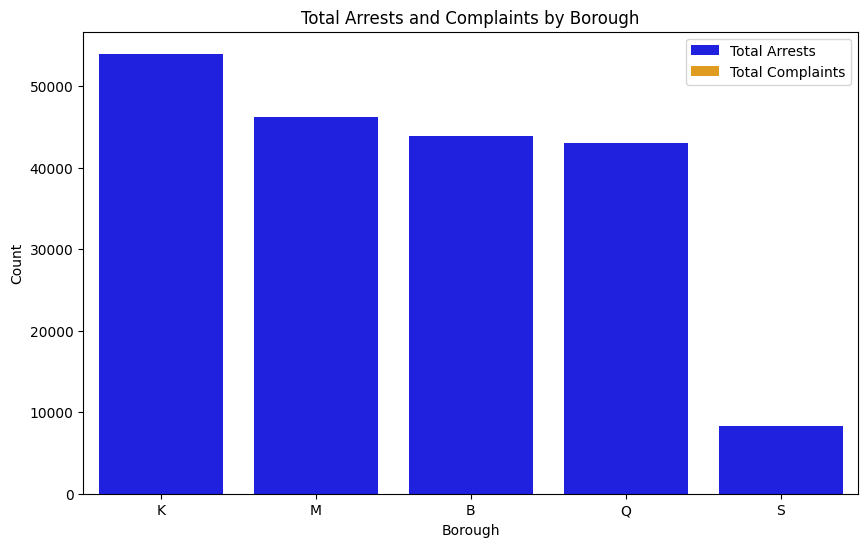

In [4]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df1, x='Borough', y='Total_Arrests', color='blue', label='Total Arrests')
sns.barplot(data=df1, x='Borough', y='Total_Complaints', color='orange', label='Total Complaints')
plt.legend()
plt.title("Total Arrests and Complaints by Borough")
plt.xlabel("Borough")
plt.ylabel("Count")
plt.show()
#Significance: This bar plot compares the total arrests and complaints reported in each borough. It helps identify areas with higher rates of arrests and complaints, which could indicate regions with more law enforcement activity or higher crime rates. For instance, a borough with many complaints but fewer arrests may suggest issues in effective policing or resource allocation.

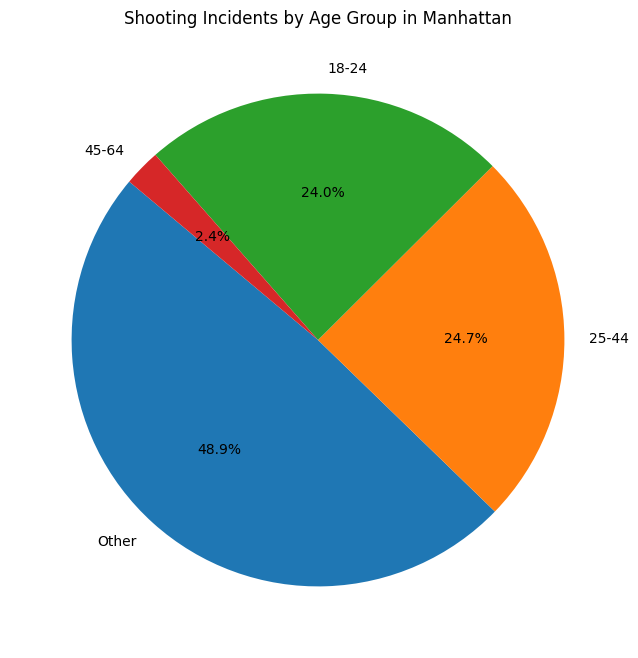

In [5]:
plt.figure(figsize=(8, 8))
plt.pie(df2['Shooting_Incidents'], labels=df2['Age_Group'], autopct='%1.1f%%', startangle=140)
plt.title("Shooting Incidents by Age Group in Manhattan")
plt.show()
#Significance: This pie chart shows the distribution of shooting incidents across different age groups in Manhattan. By visualizing which age groups are more involved in shooting incidents, this chart provides insights into demographic vulnerability, aiding in targeted intervention strategies. For instance, if young adults represent a large percentage, community programs and outreach could be prioritized for this group

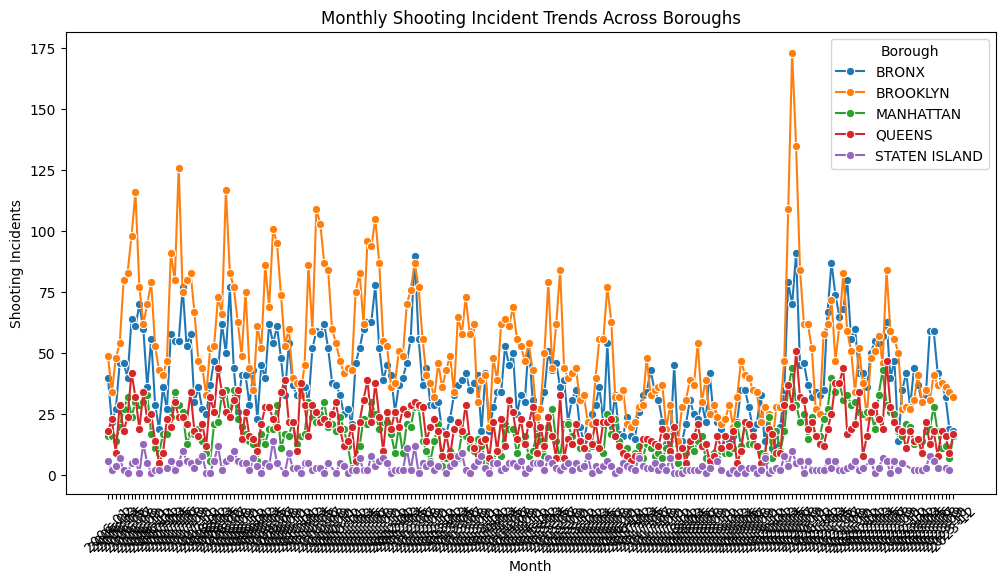

In [6]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df5_grouped, x='Month', y='Shooting_Incidents', hue='Borough', marker='o')
plt.xticks(rotation=45)
plt.title("Monthly Shooting Incident Trends Across Boroughs")
plt.xlabel("Month")
plt.ylabel("Shooting Incidents")
plt.legend(title="Borough")
plt.show()
#Significance: This line chart displays monthly trends in shooting incidents across different boroughs, showing how shooting incidents fluctuate over time and highlighting boroughs with persistent or seasonal trends. For example, a borough with consistently high incident rates across several months may indicate an area with ongoing issues in gun violence, helping direct resources more effectively for crime prevention.

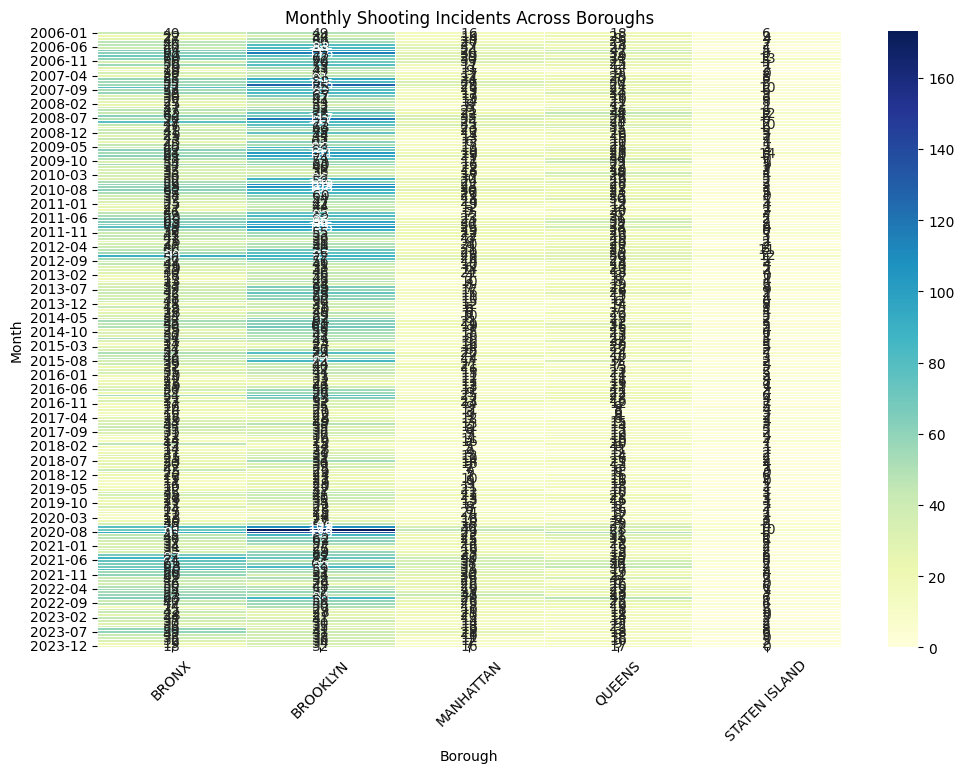

In [7]:
# Ensure 'Date' is in datetime format and create 'Month' column
df5['Date'] = pd.to_datetime(df5['Date'], errors='coerce')
df5['Month'] = df5['Date'].dt.to_period('M').astype(str)

# Aggregate shooting incidents by Month and Borough
df5_grouped = df5.groupby(['Month', 'Borough'])['Shooting_Incidents'].sum().reset_index()

# Create a pivot table for the heatmap
pivot_table = df5_grouped.pivot(index="Month", columns="Borough", values="Shooting_Incidents").fillna(0)

# Plot the heat map
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=0.5)
plt.title("Monthly Shooting Incidents Across Boroughs")
plt.xlabel("Borough")
plt.ylabel("Month")
plt.xticks(rotation=45)
plt.show()
#Significance:This heat map will allow you to quickly identify which boroughs have higher numbers of shooting incidents and whether there are any seasonal or temporal trends. For instance, if one borough consistently has higher counts in certain months, this could indicate a need for targeted interventions during that period

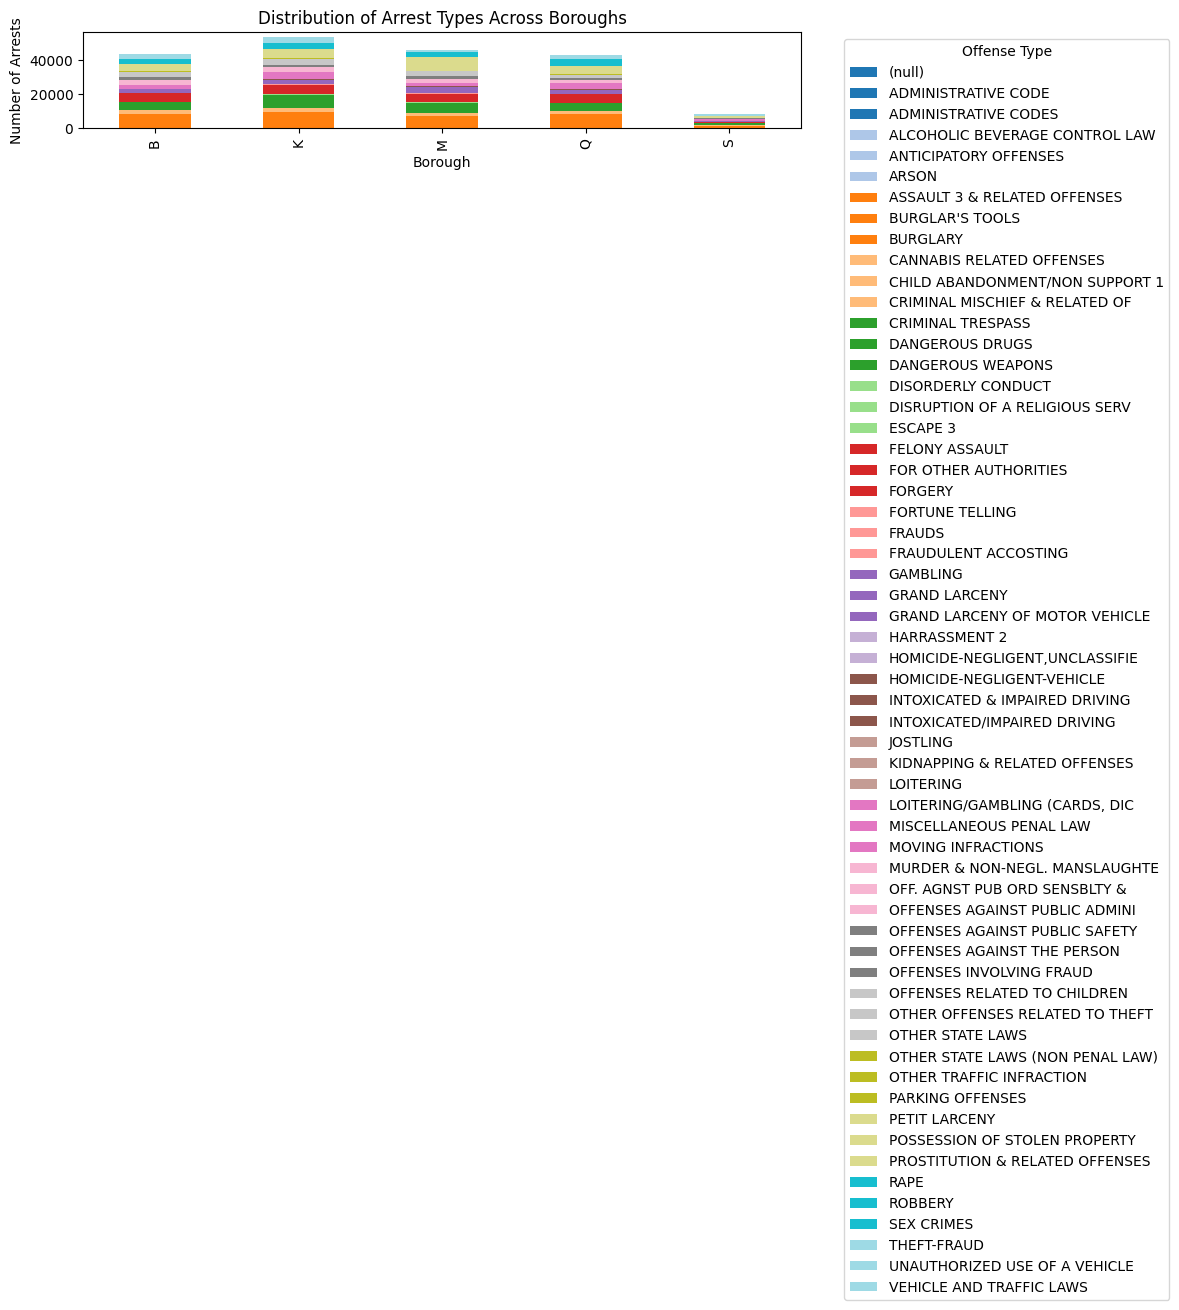

In [8]:
# Aggregate the data by borough and offense type
arrest_offense_counts = arrest_data.groupby(['ARREST_BORO', 'OFNS_DESC']).size().unstack(fill_value=0)

# Plot the stacked bar chart
arrest_offense_counts.plot(kind='bar', stacked=True, figsize=(12, 8), colormap="tab20")
plt.title("Distribution of Arrest Types Across Boroughs")
plt.xlabel("Borough")
plt.ylabel("Number of Arrests")
plt.legend(title="Offense Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
#Significance:This stacked bar chart helps in understanding the crime profile of each borough. For instance, if one borough has a higher percentage of a specific offense, such as theft or assault, law enforcement or community programs can focus on addressing that particular issue. This visualization also provides a quick comparison of which boroughs see more arrests overall.

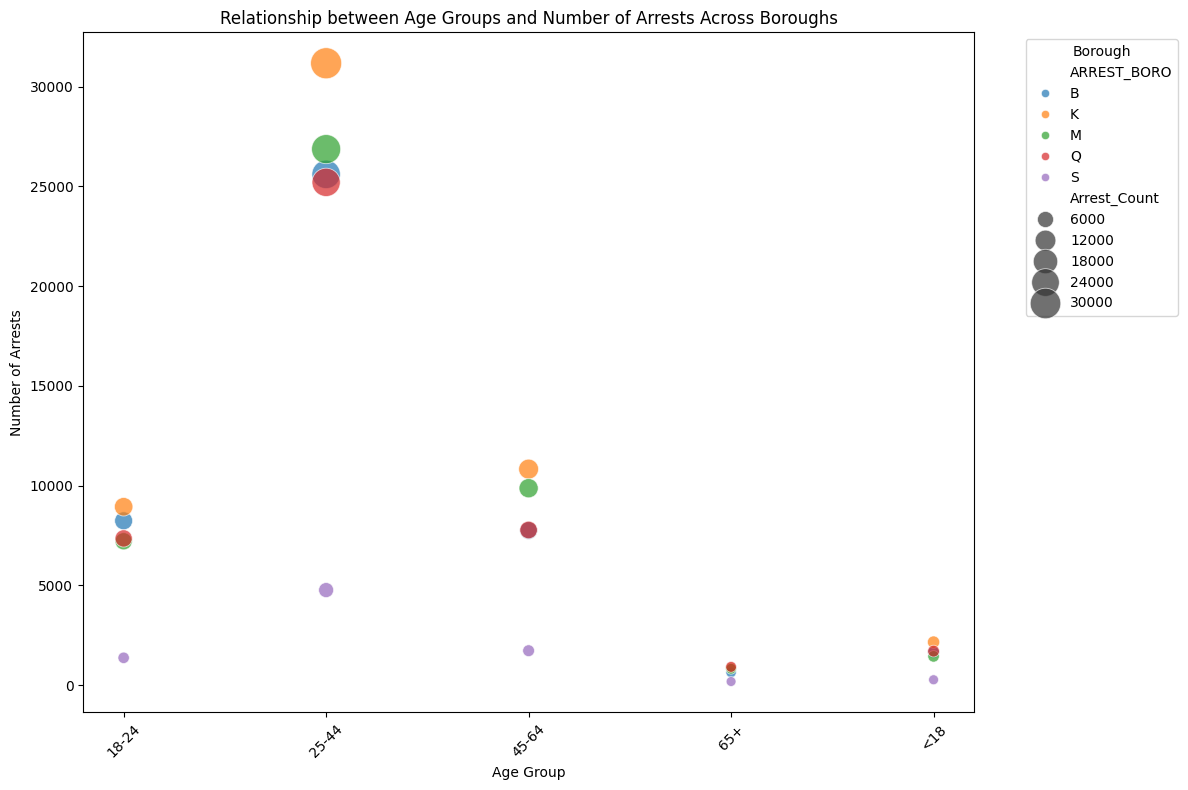

In [9]:
# Aggregate the data by borough and age group
age_arrest_counts = arrest_data.groupby(['ARREST_BORO', 'AGE_GROUP']).size().reset_index(name='Arrest_Count')

# Plot the scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=age_arrest_counts, x='AGE_GROUP', y='Arrest_Count', hue='ARREST_BORO', size='Arrest_Count', sizes=(50, 500), alpha=0.7)
plt.title("Relationship between Age Groups and Number of Arrests Across Boroughs")
plt.xlabel("Age Group")
plt.ylabel("Number of Arrests")
plt.legend(title="Borough", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
#significance:This scatter plot helps identify age groups that are more frequently involved in arrests in different boroughs. For example, if certain age groups show consistently high arrest counts in specific boroughs, community services could focus on those demographics in those areas. It also provides a quick visual comparison of the age distribution of arrests across boroughs.